In [6]:
import json
import csv
from tqdm import tqdm
import gzip
import _pickle as cPickle
import sys
from urllib.request import urlopen, Request

import nltk
from nltk import ngrams

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from proj_utils import *

In [7]:
distributions_2gram = {
    'SQuAD': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SQuAD_2gram_distribution.pickle.gz',
    'NewsQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NewsQA_2gram_distribution.pickle.gz',
    'HotpotQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/HotpotQA_2gram_distribution.pickle.gz',
    'SearchQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SearchQA_2gram_distribution.pickle.gz',
    'TriviaQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/TriviaQA_2gram_distribution.pickle.gz',
    'NaturalQuestionsShort': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NaturalQuestionsShort_2gram_distribution.pickle.gz',
}

distributions_3gram = {
    'SQuAD': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SQuAD_3gram_distribution.pickle.gz',
    'NewsQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NewsQA_3gram_distribution.pickle.gz',
    'HotpotQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/HotpotQA_3gram_distribution.pickle.gz',
    'SearchQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SearchQA_3gram_distribution.pickle.gz',
    'TriviaQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/TriviaQA_3gram_distribution.pickle.gz',
    'NaturalQuestionsShort': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NaturalQuestionsShort_3gram_distribution.pickle.gz',
}

distributions_4gram = {
    'SQuAD': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SQuAD_4gram_distribution.pickle.gz',
    'NewsQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NewsQA_4gram_distribution.pickle.gz',
    'HotpotQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/HotpotQA_4gram_distribution.pickle.gz',
    'SearchQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SearchQA_4gram_distribution.pickle.gz',
    'TriviaQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/TriviaQA_4gram_distribution.pickle.gz',
    'NaturalQuestionsShort': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NaturalQuestionsShort_4gram_distribution.pickle.gz',
}

In [8]:
def score_distributions(source, target):
    """
    Compares n-grams of two distributions
    returns:
        source_sum: total number of ngrams in source
        target_sum: total number of ngrams in target
        score_1: The sum of the ngrams in the intersection of source and target / source_sum
        score_1: The sum of the ngrams in the intersection of source and target / target_sum
    """
    shared_keys = 0
    differences = 0
    
    source_sum = sum(source.values())
    target_sum = sum(target.values())
    total_sum = source_sum + target_sum
    common_sum = 0
    
    for k,v in source.items():
        if k in target:
            shared_keys += 1
            differences += abs(v - target[k])
            common_sum += min(v, target[k])
        else:
            differences += v
    # Calculate Score common divided by target sum (pay for small predicting large).
#     source_sum = source_sum
#     common_sum = common_sum
    score_1 = common_sum/source_sum
    score_2 = common_sum/target_sum
    
    return source_sum, common_sum, score_1, score_2

def cache_distribution(distributions):
    cached_distributions = {}
    for name,url in distributions.items():
        cached_distributions[name] = get_gzip_pickle(url)
    
    return cached_distributions 



# This uses ~35GB of RAM.
To speed up iterations, the distribution files are being cached.  If the system does not have enough RAM, then try with one set of n-grams at a time.

Note, thse files are pickled NLTK fdist objects (child class of python dictionary).  The keys are tuples, which are not supported by JSON, and I felt like there might be an advantage to keeping them as ndist objects rather than joining the tuples to strings.  Was that the right decision? We'll have to wait and see. 

In [9]:
cached_distributions_2gram = cache_distribution(distributions_2gram)

Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SQuAD_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NewsQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/HotpotQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SearchQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/TriviaQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NaturalQuestionsShort_2gram_distribution.pickle.gz


In [10]:
cached_distributions_3gram = cache_distribution(distributions_3gram)

Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SQuAD_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NewsQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/HotpotQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SearchQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/TriviaQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NaturalQuestionsShort_3gram_distribution.pickle.gz


In [11]:
cached_distributions_4gram = cache_distribution(distributions_4gram)

Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SQuAD_4gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NewsQA_4gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/HotpotQA_4gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/SearchQA_4gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/TriviaQA_4gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/ablation/distributions/NaturalQuestionsShort_4gram_distribution.pickle.gz


In [12]:

def run_scoring(cached_distributions):
    """
    Iterates over distribution_#gram dicts (which have been cached above)
    """
    source_sum_final = []
    common_sum_final = []
    score_1_final = []
    score_2_final = []
    for source_name,source_distribution in tqdm(cached_distributions.items()):
        source_sum_line = []
        common_sum_line = []
        score_1_line = []
        score_2_line = []
        for target_name,target_distribution in cached_distributions.items():
            source_sum, common_sum, score_1, score_2 = score_distributions(source_distribution, target_distribution)
            
            source_sum_line.append(source_sum)
            common_sum_line.append(common_sum)
            score_1_line.append(score_1)
            score_2_line.append(score_2)

        source_sum_final.append(source_sum_line)
        common_sum_final.append(common_sum_line)
        score_1_final.append(score_1_line)
        score_2_final.append(score_2_line)
    
    return source_sum_final, common_sum_final, score_1_final, score_2_final


# source_sum_2gram, common_sum_2gram, score_1_2gram, score_2_2gram = run_scoring(cached_distributions_2gram)
# source_sum_3gram, common_sum_3gram, score_1_3gram, score_2_3gram = run_scoring(cached_distributions_3gram)
source_sum_4gram, common_sum_4gram, score_1_4gram, score_2_4gram = run_scoring(cached_distributions_4gram)


100%|██████████| 6/6 [03:37<00:00, 36.27s/it]


In [13]:

for k,v in cached_distributions_4gram.items():
    print(f"Name:{k} distinct ngrams:{len(v)} ngram sum:{sum(v.values())} ratio: {sum(v.values())/len(v)}")

Name:SQuAD distinct ngrams:2310870 ngram sum:2501689 ratio: 1.0825745282079908
Name:NewsQA distinct ngrams:5182237 ngram sum:6729830 ratio: 1.2986341612705092
Name:HotpotQA distinct ngrams:6224900 ngram sum:14174871 ratio: 2.2771242911532714
Name:SearchQA distinct ngrams:55866493 ngram sum:94759886 ratio: 1.6961846164211525
Name:TriviaQA distinct ngrams:31796672 ngram sum:50915421 ratio: 1.6012814485742408
Name:NaturalQuestionsShort distinct ngrams:7011559 ngram sum:21855118 ratio: 3.117012635848889


In [14]:
# Graph settings

#colormap = sns.cm.rocket
colormap = sns.color_palette("RdBu_r", 12)

## Training Set Distribution Intersections

`Sum of n-grams in Intersection : Total Target n-grams`

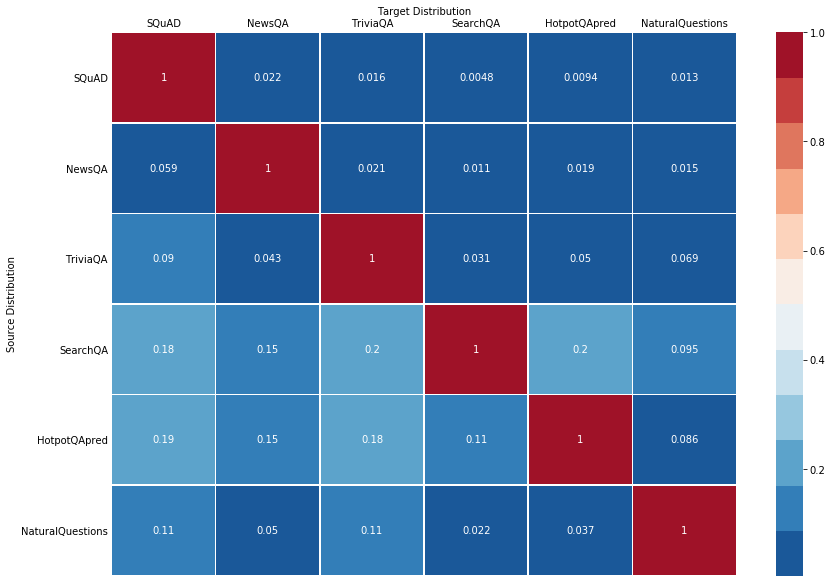

In [15]:
plt.figure(figsize=(14,10))

ax = sns.heatmap(np.array(score_2_4gram), annot=True,  linewidths=.5, cmap=colormap)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)

ax.set_xticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set_yticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set(xlabel='Target Distribution', ylabel='Source Distribution')

plt.show()

In [16]:
plt.figure(figsize=(14,10))

ax = sns.heatmap(np.array(score_2_3gram), annot=True,  linewidths=.5, cmap=colormap)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
ax.set_xticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set_yticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set(xlabel='Target Distribution', ylabel='Source Distribution')

plt.show()

NameError: name 'score_2_3gram' is not defined

<Figure size 1008x720 with 0 Axes>

## F1 Score of Models Trained on a Single Training Set to Test Sets

In [ ]:
models_parent_dir='/data/ablation/models'

results_csv = models_parent_dir+"/data/ablation/results/model_scores.csv"

scores_df = pd.read_csv(results_csv)
    
plt.figure(figsize=(14,10))

scores = scores_df.loc[scores_df['model_name'].isin(['model07', 'model08', 'model09', 'model10', 'model11', 'model12'])].pivot("model_name", "test_set_name", "f1")

# model_order=['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions', 'BioASQ', 'DROP', 'DuoRC', 'RACE', 'RelationExtraction', 'TextbookQA']
model_order=['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions']

# scores.loc[scores['model_name'] == 'model07']

ax = sns.heatmap(scores[model_order], annot=True,  linewidths=.5, center=50, cmap=colormap)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
# ax.set_xticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set_yticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set(xlabel='Test Set', ylabel='Single Training Set')

plt.show()

## F1 Score of Models Trained on a All But One Training Set to Test Sets

In [ ]:
plt.figure(figsize=(14,10))
scores_inv = scores_df.loc[scores_df['model_name'].isin(['model03', 'model02', 'model13', 'model14', 'model15', 'model16'])].pivot("model_name", "test_set_name", "f1")

# model_order=['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions', 'BioASQ', 'DROP', 'DuoRC', 'RACE', 'RelationExtraction', 'TextbookQA']
model_order=['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions']

ax = sns.heatmap(scores_inv[model_order], annot=True,  linewidths=.5, center=50, cmap=colormap)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
# ax.set_xticklabels(['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions'])
ax.set_yticklabels(['No SQuAD', 'No NewsQA', 'No TriviaQA', 'No SearchQA', 'No HotpotQApred', 'No NaturalQuestions'])
ax.set(xlabel='Test Set', ylabel='Excluded Training Set')

plt.show()

In [ ]:
scores_list = scores[model_order].values.tolist()
scores_list_flat = [j for sub in scores_list for j in sub]

# scores_list_inv = scores_inv[model_order].values.tolist()
# scores_list_inv_flat = [j for sub in scores_list_inv for j in sub]


score_1_2gram_flat = [j for sub in score_1_2gram for j in sub]
score_2_2gram_flat = [j for sub in score_2_2gram for j in sub]
source_sum_2gram_flat = [j for sub in source_sum_2gram for j in sub]
common_sum_2gram_flat = [j for sub in common_sum_2gram for j in sub]

score_1_3gram_flat = [j for sub in score_1_3gram for j in sub]
score_2_3gram_flat = [j for sub in score_2_3gram for j in sub]
source_sum_3gram_flat = [j for sub in source_sum_3gram for j in sub]
common_sum_3gram_flat = [j for sub in common_sum_3gram for j in sub]


In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = []
y = []
for x1,x2,x3,x4,y1 in zip(score_1_3gram_flat,
                          score_2_3gram_flat, 
                          source_sum_3gram_flat, 
                          common_sum_3gram_flat, 
                          scores_list_flat):
    if x1 != x2 and x1 != 1.0:
#         print([x1,x2,x3,x4])
        x.append([x4])
        y.append(y1)
        


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

r_sq = model.score(x[1:], y[1:])
print('R-Squared:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

In [ ]:
# None of this makes sense (need to combine distribution sets)

# x = []
# y = []
# for x1,x2,x3,x4,y1 in zip(score_1_2gram_flat,
#                           score_2_2gram_flat, 
#                           source_sum_2gram_flat, 
#                           common_sum_2gram_flat, 
#                           scores_list_inv_flat):
#     if x1 == x2 and x1 == 1.0:
# #     if x1 != x2 and x1 != 1.0:
# #         print([x1,x2,x3,x4])
#         x.append([x3])
#         y.append(y1)
        


# model = LinearRegression()
# model.fit(x, y)

# y_pred = model.predict(x)

# r_sq = model.score(x, y)
# print('R-Squared:', r_sq)
# print('intercept:', model.intercept_)
# print('coefficients:', model.coef_)

In [ ]:
import statsmodels.api as sm
# X = sm.add_constant(X.ravel())

results = sm.OLS(y,x).fit()
y_pred2 = results.predict(x)
results.summary()  

In [ ]:
for orig, pred in zip(y, y_pred2):
    print(f"Orig: {orig:.3f}\t Pred: {pred:.3f}\t Diff: {abs(orig-pred):.3f}")